In [1]:
from typing import List

import torch
from PIL import Image
from torchvision.datasets import CIFAR10
from diffusers import StableDiffusionPipeline

/vol/biomedic3/rrr2417/cxr-generation/notebooks/diffedit_diffusers/lib/python3.9/site-packages/transformers/utils/hub.py:123: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(


In [84]:
from torchvision import transforms

preprocess = transforms.Compose(
    [
        transforms.Resize((64, 64)),
        # transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5]),
    ]
)

In [2]:
dataset = CIFAR10(root="~/.cache", download=True)

Files already downloaded and verified


In [64]:
pipe = StableDiffusionPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5",
    torch_dtype=torch.float16,
)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.


In [128]:
from torch.distributions.uniform import Uniform
from tqdm import tqdm


def denoise_cfg(
    model: StableDiffusionPipeline,
    noisy_image: torch.tensor,
    text: str,
):
    for t in tqdm(model.scheduler.num_inference_steps):
        pass
    pass


def generative_classification_clark(
    model: StableDiffusionPipeline,
    image: Image.Image,
    classes: List[str],
    min_scores: int = 20,
    max_scores: int = 2000,
    cutoff_pval: float = 2e-3,
):
    image = preprocess(image)
    scheduler = model.scheduler
    dist = Uniform(torch.tensor([0.]), torch.tensor([scheduler.num_train_timesteps]))
    
    scores = {_class: [] for _class in classes}
    n = 0
    while len(scores) > 1 and n < max_scores:
        n += 1
        
        # Noise the image by sampling t ~ U[0,1] then generating x_t ~ q(x_t|x)
        t = torch.LongTensor([dist.rsample())])
        noise = torch.randn(image.shape)
        noisy_image = scheduler.add_noise(image, noise, t)
        
        min_mean = float("inf")
        min_mean_class = None
        for _class, score in scores.items():
            # TODO: Text conditioning
            noise_pred = model(noisy_image, t, return_dict=False)[0]
            print(noise_pred)
            denoised_image = noisy_image - noise_pred
            score.append(l2_norm(image - denoised_image))
            if (class_mean := math.mean(score)) < min_mean:
                min_mean = class_mean
                min_mean_class = _class
            
        if n >= min_scores:
            for _class, score in scores.items():
                if _class == min_mean_class:
                    continue
                if paired_ttest_pval(scores[min_mean_class], scores[_class]) < cutoff_pval:
                    del scores[_class]

        min_mean = float("inf")
        min_mean_class = None

    assert len(scores) == 1
    return list(scores.keys())[0]

In [138]:
generative_classification_clark(
    pipe, raw_image, ["cat", "dog"],
)

torch.Size([3, 64, 64])


ValueError: `height` and `width` have to be divisible by 8 but are 770 and 512.

In [146]:
# from torchvision.transforms.functional import pil_to_tensor, to_pil_image
# from torchvision.io import read_image, ImageReadMode
# import torch
# from diffusers import DDPMScheduler

# # noise_scheduler = DDPMScheduler(num_train_timesteps=1000)
noise_scheduler = pipe.scheduler  # (num_train_timesteps=1000)
raw_image = Image.open("cat_mirror.jpeg")
sample_image = preprocess(raw_image)
noisy = noise_scheduler.add_noise(
    sample_image,
    torch.randn(sample_image.shape),
    torch.LongTensor([10]),
)

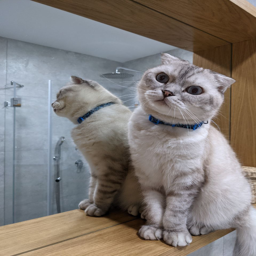

In [147]:
raw_image.resize((256, 256))

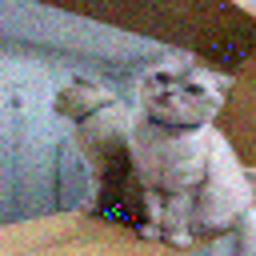

In [148]:
to_pil_image(((noisy.permute(1, 2, 0) + 1) * 127.5).type(torch.uint8).numpy()).resize((256, 256))

In [150]:
pipe(noisy, torch.LongTensor([10]))

ValueError: `height` and `width` have to be divisible by 8 but are tensor([10]) and 512.

In [143]:
pipe(noisy.unsqueeze(0), timestep=0)

ValueError: `prompt` has to be of type `str` or `list` but is <class 'torch.Tensor'>